In [1]:
import wandb
import numpy as np
import pandas as pd
import data_loader as DL
import classifiers as CLASS
from utilities import save_results, print_resutls
from evaluation import evaluate_classifier
from imputation_utilities import load_imputed_data
import joblib

In [2]:
import shap

In [3]:
from glob import glob
from scipy.stats import skew
KK = glob('saved_models_for_interp/XG*.pth')+glob('saved_models_for_interp/Ran*.pth')+glob('saved_models_for_interp/NG*.pth')
KK[:1]

['saved_models_for_interp/XGBoost_SYNTHETIC_MICE_0.25_0.25_3.0_2.0_7.pth']

In [4]:
cols = ['classifier','dataset','imputation','train','test','val','holdout','m']+list(np.arange(25))

In [61]:
from tqdm import tqdm

def main_imp(KK):
    
    for kk in tqdm(KK):

        ## initial setup
        classifier_choice, dataset_choice, imputation_choice, train_percentage, test_percentage, validation_set, holdout_set, m_1 =  kk.split('/')[-1].split('_')
        mm = int(m_1.split('.')[0])
        train_percentage = float(train_percentage)
        test_percentage = float(test_percentage)
        validation_set = float(validation_set)
        holdout_set = float(holdout_set)

        # If user wants to run only a single scenario (default):
        # Generate scenario based on args
        scenario = pd.Series({
                            'holdout_set': holdout_set, 
                            'validation_set':validation_set, 
                            'train_percentage':train_percentage, 
                            'test_percentage':test_percentage
                            })

        ## LOAD DATA
        data_load = DL.dataLoader(dataset_choice)
        train_x, train_y0, val_x, val_y0, test_x, test_y0 = data_load.runDataLoader(scenario)

        ## LOAD IMPUTED DATA (as np.array)
        results_val, results_test = [], []
        for m in [mm]:
            imputed_train_x, imputed_val_x, imputed_test_x = load_imputed_data(
                dataset_choice=dataset_choice,
                imputation_choice=imputation_choice,
                imputation_hparam=-1,
                train_percentage=train_percentage,
                test_percentage=test_percentage,
                validation_set=validation_set,
                holdout_set=holdout_set,
                m=m)

            flag_nan = 0         
            if pd.DataFrame(imputed_train_x).isna().any(axis=1).sum() > 0 or pd.DataFrame(imputed_val_x).isna().any(axis=1).sum() > 0 or pd.DataFrame(imputed_test_x).isna().any(axis=1).sum() > 0:

                imputed_train_x0 = pd.DataFrame(imputed_train_x)
                imputed_val_x0 = pd.DataFrame(imputed_val_x)
                imputed_test_x0 = pd.DataFrame(imputed_test_x)

                imputed_train_x = np.array(imputed_train_x0.loc[~imputed_train_x0.isna().any(axis=1)])
                imputed_val_x = np.array(imputed_val_x0.loc[~imputed_val_x0.isna().any(axis=1)])
                imputed_test_x = np.array(imputed_test_x0.loc[~imputed_test_x0.isna().any(axis=1)])

                train_y = train_y0.loc[~imputed_train_x0.isna().any(axis=1)]
                if classifier_choice[:6] == 'Robust':
                    val_y   = val_y0
                    test_y  = test_y0
                else:
                    val_y   = val_y0.loc[~imputed_val_x0.isna().any(axis=1)]
                    test_y  = test_y0.loc[~imputed_test_x0.isna().any(axis=1)]

                idx_train = list((train_y0[imputed_train_x0.isna().any(axis=1)]).index)
                if classifier_choice[:6] == 'Robust':
                    idx_val = []
                    idx_test = []
                else:
                    idx_val = list((val_y0[imputed_val_x0.isna().any(axis=1)]).index)
                    idx_test = list((test_y0[imputed_test_x0.isna().any(axis=1)]).index)
                print(idx_train, idx_val, idx_test)
                flag_nan = 1

            else:

                train_y = train_y0
                val_y   = val_y0
                test_y  = test_y0


            print('classify...')
            ## PERFORM CLASSIFICATION
            CLS = CLASS.classifyImputedValues(classifier_choice,dataset_choice) 
            #print(hparams)

            fail_state = 0
            model = joblib.load(kk)

            #print('completes_classification')
            #prediction_prob_val = model.predict_proba(imputed_val_x)[:,1]
            #prediction_prob_test = model.predict_proba(imputed_test_x)[:,1]

            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X = imputed_train_x, y = train_y0)

            try:
                print(shap_values.shape)
                #shap_vals = np.mean(np.abs(shap_values),0)
                shap_vals = skew(shap_values,0)
                #shap.summary_plot(shap_values, imputed_train_x)
            except:
                #shap_vals = np.mean(np.abs(shap_values[1]),0)
                shap_vals = skew(shap_values[1],0)
                #shap.summary_plot(shap_values[1], imputed_train_x)
                
            return shap_vals
            

In [62]:
import warnings
warnings.filterwarnings("ignore")

kk10 = 0
for kk in KK:
    s1 = main_imp([kk])
    pd_temp = pd.DataFrame(kk.split('.p')[0].split('/')[-1].split('_') + list(s1), index=cols).transpose()
    
    if kk10 == 0:
        pd_final = pd_temp.copy()
    else:
        pd_final = pd.concat([pd_final,pd_temp.copy()],0)
    kk10+=1

  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_7/
classify...
[14:58:09] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:09] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:09] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:02<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_9/
classify...
[14:58:10] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:10] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:10] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_6/
classify...
[14:58:12] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:12] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:12] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_3/
classify...
[14:58:13] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:13] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:13] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_6/
classify...
[14:58:14] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:14] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:14] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_6/
classify...
[14:58:15] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:15] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:15] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_5/
classify...
[14:58:16] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:16] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:16] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_9/
classify...
[14:58:17] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:17] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:17] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_8/
classify...
[14:58:18] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:18] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:18] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_8/
classify...
[14:58:19] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:19] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:19] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_2/
classify...
[14:58:20] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:20] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:20] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_3/
classify...
[14:58:21] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:21] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:21] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_3/
classify...
[14:58:22] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:22] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:22] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_9/
classify...
[14:58:23] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:23] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:23] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_4/
classify...
[14:58:24] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:24] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:24] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_3/
classify...
[14:58:25] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:25] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:25] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_5/
classify...
[14:58:26] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:26] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:27] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_1/
classify...
[14:58:28] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:28] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:28] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_8/
classify...
[14:58:29] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:29] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:29] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_3/
classify...
[14:58:30] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:30] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:30] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_0/
classify...
[14:58:31] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:31] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:31] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_2/
classify...
[14:58:32] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:32] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:32] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_4/
classify...
[14:58:33] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:33] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:33] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_5/
classify...
[14:58:34] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:34] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:34] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_9/
classify...
[14:58:35] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:35] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:35] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_0/
classify...
[14:58:36] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:36] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:36] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_8/
classify...
[14:58:37] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:37] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:37] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_5/
classify...
[14:58:38] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:38] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:38] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_3/
classify...
[14:58:39] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:39] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:39] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_4/
classify...
[14:58:40] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:40] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:40] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_1/
classify...
[14:58:41] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:41] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:41] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_5/
classify...
[14:58:43] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:43] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:43] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_4/
classify...
[14:58:44] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:44] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:44] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_8/
classify...
[14:58:45] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:45] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:45] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_6/
classify...
[14:58:46] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:46] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:46] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_5/
classify...
[14:58:47] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:47] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:47] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_8/
classify...
[14:58:48] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:48] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:48] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_8/
classify...
[14:58:49] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:49] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:49] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_4/
classify...
[14:58:50] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:50] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:50] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_4/
classify...
[14:58:51] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:51] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:51] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_2/
classify...
[14:58:52] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:52] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:52] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_3/
classify...
[14:58:53] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:53] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:53] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_2/
classify...
[14:58:54] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:54] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:54] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_5/
classify...
[14:58:55] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:55] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:55] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_6/
classify...
[14:58:56] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:56] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:56] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_3/
classify...
[14:58:57] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:57] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:57] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_1/
classify...
[14:58:58] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:58] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:58] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_6/
classify...
[14:58:59] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:58:59] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:58:59] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_2/
classify...
[14:59:00] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:00] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:00] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_1/
classify...
[14:59:01] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:01] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:01] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_9/
classify...
[14:59:02] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:02] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:02] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_7/
classify...
[14:59:03] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:03] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:03] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_1/
classify...
[14:59:04] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:04] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:04] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_3/
classify...
[14:59:05] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:05] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:05] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_1/
classify...
[14:59:06] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:06] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:06] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_1/
classify...
[14:59:07] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:07] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:07] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_9/
classify...
[14:59:08] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:08] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:08] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_0/
classify...
[14:59:09] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:09] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:09] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_3/
classify...
[14:59:10] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:10] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:10] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_7/
classify...
[14:59:11] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:11] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:11] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_5/
classify...
[14:59:12] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:12] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:12] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_1/
classify...
[14:59:13] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:13] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:13] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_7/
classify...
[14:59:15] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:15] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:15] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_2/
classify...
[14:59:16] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:16] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:16] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_0/
classify...
[14:59:17] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:17] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:17] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_6/
classify...
[14:59:18] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:18] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:18] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_1/
classify...
[14:59:19] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:19] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:19] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_8/
classify...
[14:59:20] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:20] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:20] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_4/
classify...
[14:59:21] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:21] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:21] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_0/
classify...
[14:59:22] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:22] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:22] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_2/
classify...
[14:59:23] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:23] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:23] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_9/
classify...
[14:59:24] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:24] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:24] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_8/
classify...
[14:59:25] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:25] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:25] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_4/
classify...
[14:59:26] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:26] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:26] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_7/
classify...
[14:59:27] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:27] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:27] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_2/
classify...
[14:59:28] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:28] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:28] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_0/
classify...
[14:59:29] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:29] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:29] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_5/
classify...
[14:59:30] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:30] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:30] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_6/
classify...
[14:59:31] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:31] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:31] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_4/
classify...
[14:59:32] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:32] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:32] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_7/
classify...
[14:59:33] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:33] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:33] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_8/
classify...
[14:59:34] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:34] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:34] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_9/
classify...
[14:59:35] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:35] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:35] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_7/
classify...
[14:59:36] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:36] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:36] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_9/
classify...
[14:59:37] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:37] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:37] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_4/
classify...
[14:59:39] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:39] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:39] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_2.0/m_6/
classify...
[14:59:40] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:40] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:40] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_7/
classify...
[14:59:41] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:41] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:41] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_1.0/m_2/
classify...
[14:59:42] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:42] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:42] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_0/
classify...
[14:59:43] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:43] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:43] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_0/
classify...
[14:59:44] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:44] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:44] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_5/
classify...
[14:59:45] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:45] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:45] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_7/
classify...
[14:59:46] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:46] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:46] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_0.0/m_2/
classify...
[14:59:47] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:47] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:47] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_6/
classify...
[14:59:48] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:48] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:48] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_7/
classify...
[14:59:49] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:49] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:49] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_1/
classify...
[14:59:50] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:50] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:50] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_3.0/m_9/
classify...
[14:59:51] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:51] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:51] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_2.0/val_4.0/m_0/
classify...
[14:59:52] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:52] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:52] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:01<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_0/
classify...
[14:59:53] WARNING: ../src/learner.cc:1040: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:59:53] WARNING: ../src/learner.cc:749: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
[14:59:53] WARNING: ../src/learner.cc:438: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current versi

  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_3/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_3/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_4/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_9/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_9/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_1/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_6/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_4/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_5/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_5/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_9/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_4/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_2/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_6/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_4/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_6/


  0%|          | 0/1 [00:00<?, ?it/s]

classify...



  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_4/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_7/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_3/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_6/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_3/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_8/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_7/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_0/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_1/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_8/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_0/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_6/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_3/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_3/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_1/


  0%|          | 0/1 [00:00<?, ?it/s]

classify...



  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_5/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_7/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_2/


  0%|          | 0/1 [00:00<?, ?it/s]

classify...



  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_2/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_7/


  0%|          | 0/1 [00:00<?, ?it/s]


classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/Mean/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_7/


  0%|          | 0/1 [00:00<?, ?it/s]

classify...



  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_5/
classify...


  0%|          | 0/1 [00:02<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_7/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_0/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_1/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_1.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_0.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(532, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_3/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_5/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_0.0/m_6/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_4.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_2.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_3.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_3.0/m_2/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_4.0/m_8/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(534, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/MICE/hparam_-1/train_per_0.25/test_per_0.25/holdout_1.0/val_1.0/m_9/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]


(533, 25)


  0%|          | 0/1 [00:00<?, ?it/s]

IMPUTED_DATA/SYNTHETIC/GAIN/hparam_-1/train_per_0.25/test_per_0.25/holdout_0.0/val_2.0/m_4/
classify...


  0%|          | 0/1 [00:00<?, ?it/s]

(533, 25)


In [63]:
pd_final

classifier    dataset imputation train  test  val holdout  m         0  \
0     XGBoost  SYNTHETIC       MICE  0.25  0.25  3.0     2.0  7  0.497635   
0     XGBoost  SYNTHETIC       MICE  0.25  0.25  1.0     2.0  9 -0.258541   
0     XGBoost  SYNTHETIC       GAIN  0.25  0.25  2.0     0.0  6 -0.012668   
0     XGBoost  SYNTHETIC       MICE  0.25  0.25  1.0     2.0  3  0.000451   
0     XGBoost  SYNTHETIC       GAIN  0.25  0.25  3.0     0.0  6  0.140254   
..        ...        ...        ...   ...   ...  ...     ... ..       ...   
0     NGBoost  SYNTHETIC       GAIN  0.25  0.25  3.0     0.0  2 -0.132104   
0     NGBoost  SYNTHETIC       MICE  0.25  0.25  4.0     1.0  8 -0.515175   
0     NGBoost  SYNTHETIC       GAIN  0.25  0.25  2.0     0.0  9 -0.588245   
0     NGBoost  SYNTHETIC       MICE  0.25  0.25  1.0     1.0  9 -0.460948   
0     NGBoost  SYNTHETIC       GAIN  0.25  0.25  2.0     0.0  4 -0.348404   

           1  ...        15        16        17        18        19        20  \
0   0.413777  ...   0.95851 -1.372589  0.045717 -0.447855  0.959537  0.593771   
0   0.109684  ...  1.755853 -1.240995  0.029824  0.356393  0.486076  0.637109   
0   0.272866  ...  1.023202 -1.919026  -0.97672 -1.188894 -0.305402  0.570772   
0   0.214372  ...  1.903418 -0.589666   0.95076 -0.703998  0.106372  0.694773   
0   0.747176  ...  1.413922 -0.969505 -0.696123 -1.072543 -0.441872  0.407788   
..       ...  ...       ...       ...       ...       ...       ...       ...   
0    0.54318  ...    1.1774 -1.401146 -1.784897 -1.198418 -1.710989  1.066392   
0  -0.676157  ...  1.101389 -1.303094 -2.146863  0.281811 -2.932543  0.241979   
0   0.078082  ...  0.529721 -0.999037  0.202328 -1.277653 -1.126091   0.77846   
0  -0.553372  ...  1.089118 -1.245967 -1.485195 -0.627006  1.890427  0.379459   
0   0.133771  ...  1.017346 -3.574357 -2.519534 -1.255624 -1.174133  0.925969   

          21        22        23        24  
0   0.714557 -0.522958 -0.762319  1.170025  
0   1.288294   0.23228 -0.085349 -0.122901  
0   0.450897 -1.478764 -0.733465  -0.18509  
0   1.069117  0.239688 -0.914748   0.51141  
0   1.520712 -1.127889  -0.06494 -0.415341  
..       ...       ...       ...       ...  
0   0.994829 -1.575763 -0.222812 -0.073067  
0   0.513978  0.154244  0.486561  0.901039  
0   0.793685 -1.680208 -1.422796 -0.754413  
0   1.055798 -0.633133  0.378715 -0.383621  
0  -1.365237 -1.270565 -0.014007 -0.625966  

[300 rows x 33 columns]

In [64]:
pd_reduced = pd_final.groupby(['classifier','dataset','imputation','train','test','m'], as_index=False).mean()#.to_csv('interp_prelim.csv')
pd_reduced = pd_reduced.groupby(['classifier','dataset','imputation','train','test'], as_index=False).mean()#.abs()

In [65]:
for classifier in pd_reduced['classifier'].unique():
    print(classifier)
    pd_reduced_c = pd_reduced.loc[pd_reduced['classifier']==classifier]
    
    for imp_m in pd_reduced_c['imputation'].unique():
        if imp_m == 'MICE':
            best_df = pd_reduced_c.loc[pd_reduced_c['imputation']=='MICE']
            best_arr = np.array(best_df[best_df.columns[5:]].abs())
        else:
            worst_df = pd_reduced_c.loc[pd_reduced_c['imputation']!='MICE']
            worst_arr = np.array(worst_df[worst_df.columns[5:]].abs())
        
    count = 0
    for b,w in zip(best_arr[0],worst_arr[0]):
        if b<w:
            count+=1
    print(str(count)+'/'+str(len(worst_arr[0])))

NGBoost
20/25
RandomForest
22/25
XGBoost
15/25


In [66]:
#if not os.path.exists('interp_final_MR.csv')
#    pd_reduced.to_csv('interp_final_MR.csv')

SyntaxError: expected ':' (4004301558.py, line 1)

In [ ]:
#pd_reduced = pd.read_csv('interp_final_MR.csv')

In [76]:
worst_df['imputation'].iloc[0]

'GAIN'

5
5
5


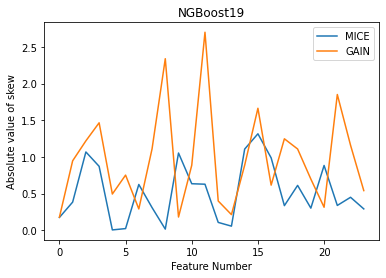

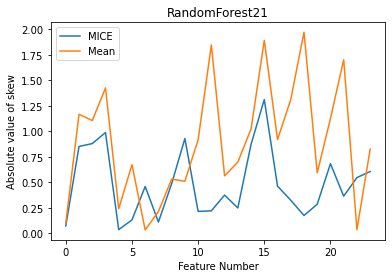

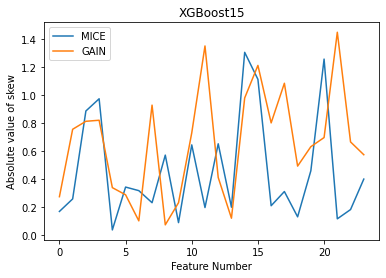

In [82]:
import matplotlib.pyplot as plt

for class1 in pd_reduced['classifier'].unique(): #range(len(pd_reduced2)):
    
    pd_reduced_temp = pd_reduced.loc[pd_reduced['classifier']==class1]
    vals = pd_reduced_temp[pd_reduced_temp.columns[6:]]
    
    
    best_df = pd_reduced_temp.loc[pd_reduced_temp['imputation']=='MICE']
    worst_df = pd_reduced_temp.loc[pd_reduced_temp['imputation']!='MICE']
    best_vals_df = vals.loc[pd_reduced_temp['imputation']=='MICE'].abs()
    worst_vals_df = vals.loc[pd_reduced_temp['imputation']!='MICE'].abs()
    
    fig, ax = plt.subplots(nrows=1,ncols=1)
    ax.plot(np.array(best_vals_df)[0], label='MICE')
    ax.plot(np.array(worst_vals_df)[0], label=worst_df['imputation'].iloc[0])
    plt.title(class1+str(len(np.where(np.array(worst_vals_df)[0] - np.array(best_vals_df)[0]>0)[0])))
    plt.legend()
    plt.ylabel('Absolute value of skew')
    plt.xlabel('Feature Number')
    print(row)

In [81]:
pd_reduced['classifier'].unique()

array(['NGBoost', 'RandomForest', 'XGBoost'], dtype=object)

In [ ]:
class1